# Regression Modeling: Wanderdauer-Vorhersage - Schweizer Wanderwege

Dieses Notebook implementiert Regressionsmodelle zur Vorhersage der Wanderdauer basierend auf verschiedenen Wanderweg-Eigenschaften.

**Projektziel:**
- Erfüllung von Anforderung (5): "Use of regression as the modeling method"
- Erfüllung von Anforderung (6): "Model evaluation using R², RMSE, MAE"
- Erfüllung von Anforderung (7): "Correct interpretation of model results and measures of fit"

**Fragestellung:**
*"Wie lange dauert eine Wanderung basierend auf Distanz, Höhenprofil, Schwierigkeit und geografischer Lage?"*

---

**Hinweis:** Data Preparation und EDA wurden bereits in den vorherigen Notebooks durchgeführt:
- `02_data_preparation.ipynb`: Datenaufbereitung und Speicherung in MySQL
- `04_exploratory_data_analysis.ipynb`: Exploratory Data Analysis


## 1. Setup & Daten laden


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import utility functions for cleaner code
from db_utils import read_from_db, setup_display_settings, setup_visualization_settings

# Setup display and visualization settings
setup_display_settings(float_format='{:.2f}', precision=3)
setup_visualization_settings()

print("Libraries erfolgreich importiert")


✅ Display settings configured
✅ Visualization settings configured
Libraries erfolgreich importiert


In [2]:
# Load data from MySQL database using utility function
df = read_from_db("SELECT * FROM wanderwege")

# Display first rows
df.head()


✅ Loaded 375 rows, 13 columns from database


,url,title,location,canton,difficulty_level,difficulty_num,duration_min,distance_km,ascent_m,descent_m,physical_demand,latitude,longitude
0,https://www.schweizer-wanderwege.ch/de/wanderv...,Husky-Traum,Muotathal,None,None,NaN,NaN,0.00,NaN,NaN,hoch,46.97,8.77
1,https://www.schweizer-wanderwege.ch/de/wanderv...,Aufregende Ausblicke auf dem Hochalp Trail,"Urnäsch, Anker",AR,None,NaN,405.00,11.40,720.00,720.00,hoch,47.31,9.28
2,https://www.schweizer-wanderwege.ch/de/wanderv...,Den ganzen Tag im Schnee,"Atzmännig SSA — Atzmännig, Schutt",SG,None,NaN,100.00,4.20,140.00,510.00,mittel,NaN,NaN
3,https://www.schweizer-wanderwege.ch/de/wanderv...,Panorama Trail in Obwalden,Langis,OW,None,NaN,270.00,12.30,565.00,565.00,hoch,46.89,8.13
4,https://www.schweizer-wanderwege.ch/de/wanderv...,Schneeschuhwanderung auf den Chasseron,"Les Rasses, village",VD,None,NaN,260.00,10.00,450.00,450.00,hoch,46.83,6.55


## 2. Daten für Modeling vorbereiten


In [3]:
# Select features for modeling
print("="*80)
print("FEATURE SELECTION FÜR MODELING")
print("="*80)

# Remove rows with missing values in key columns
df_model = df.dropna(subset=['duration_min', 'distance_km', 'ascent_m', 'descent_m', 'difficulty_num']).copy()

print(f"\nDatensätze nach Bereinigung: {len(df_model)} (von {len(df)} ursprünglich)")

# difficulty_num ist bereits in der Datenbank gespeichert (aus 02_data_preparation.ipynb)
# Kein erneutes Mapping erforderlich - Single Source of Truth!

# Define features
features = ['distance_km', 'ascent_m', 'descent_m', 'difficulty_num']

# Create feature matrix X and target y
X = df_model[features].copy()
y = df_model['duration_min'].copy()

# Handle any remaining NaN values
X = X.fillna(X.median())

print(f"\nAusgewählte Features ({len(features)}):")
for i, feat in enumerate(features, 1):
    print(f"   {i}. {feat}")

print(f"\nFeature Matrix: {X.shape}")
print(f"Target Variable: {y.shape}")

# Display basic statistics
print(f"\nTarget Variable Statistik:")
print(f"   Mean: {y.mean():.1f} Minuten")
print(f"   Median: {y.median():.1f} Minuten")
print(f"   Std: {y.std():.1f} Minuten")
print(f"   Min: {y.min():.1f} Minuten")
print(f"   Max: {y.max():.1f} Minuten")


FEATURE SELECTION FÜR MODELING

Datensätze nach Bereinigung: 101 (von 375 ursprünglich)

Ausgewählte Features (4):
   1. distance_km
   2. ascent_m
   3. descent_m
   4. difficulty_num

Feature Matrix: (101, 4)
Target Variable: (101,)

Target Variable Statistik:
   Mean: 180.4 Minuten
   Median: 180.0 Minuten
   Std: 56.0 Minuten
   Min: 60.0 Minuten
   Max: 350.0 Minuten


## 3. Train-Test Split


In [4]:
# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

print(f"\nTraining set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTarget Variable Statistik:")
print(f"  Training - Mean: {y_train.mean():.1f} min, Std: {y_train.std():.1f} min")
print(f"  Test     - Mean: {y_test.mean():.1f} min, Std: {y_test.std():.1f} min")


TRAIN-TEST SPLIT

Training set: 80 samples (79.2%)
Test set: 21 samples (20.8%)

Target Variable Statistik:
  Training - Mean: 180.9 min, Std: 56.3 min
  Test     - Mean: 178.3 min, Std: 55.9 min


## 4. Model 1: Linear Regression (OLS)


In [5]:
# Train Linear Regression model
print("="*80)
print("MODEL 1: LINEAR REGRESSION (Ordinary Least Squares)")
print("="*80)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluation metrics
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)

print(f"\n Performance Metrics:")
print(f"   Training R²:  {train_r2_lr:.4f}")
print(f"   Test R²:      {test_r2_lr:.4f}")
print(f"   Training RMSE: {train_rmse_lr:.2f} Minuten")
print(f"   Test RMSE:     {test_rmse_lr:.2f} Minuten")
print(f"   Test MAE:      {test_mae_lr:.2f} Minuten")

print(f"\n INTERPRETATION:")
print(f"   • Das Modell erklärt {test_r2_lr*100:.1f}% der Varianz in der Wanderdauer")
print(f"   • Durchschnittlicher Fehler: ±{test_mae_lr:.0f} Minuten")
print(f"   • RMSE von ±{test_rmse_lr:.0f} Minuten bedeutet typische Vorhersage-Unsicherheit")


MODEL 1: LINEAR REGRESSION (Ordinary Least Squares)

 Performance Metrics:
   Training R²:  0.9808
   Test R²:      0.9818
   Training RMSE: 7.76 Minuten
   Test RMSE:     7.35 Minuten
   Test MAE:      5.66 Minuten

 INTERPRETATION:
   • Das Modell erklärt 98.2% der Varianz in der Wanderdauer
   • Durchschnittlicher Fehler: ±6 Minuten
   • RMSE von ±7 Minuten bedeutet typische Vorhersage-Unsicherheit


In [6]:
# Display coefficients (interpretability)
print("\n" + "="*80)
print("LINEAR REGRESSION COEFFICIENTS (Interpretierbarkeit)")
print("="*80)

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nIntercept (Basiswert): {lr_model.intercept_:.2f} Minuten")
print("\nFeature Coefficients:")
print(coef_df[['Feature', 'Coefficient']].to_string(index=False))

print("\n INTERPRETATION:")
print(f"   • Intercept: {lr_model.intercept_:.0f} min (Basis-Wanderzeit)")
for idx, row in coef_df.head(3).iterrows():
    if 'distance' in row['Feature']:
        print(f"   • {row['Feature']}: +{row['Coefficient']:.2f} min pro km")
    elif 'ascent' in row['Feature'] or 'descent' in row['Feature']:
        print(f"   • {row['Feature']}: +{row['Coefficient']:.2f} min pro Meter")
    elif 'difficulty' in row['Feature']:
        print(f"   • {row['Feature']}: +{row['Coefficient']:.2f} min pro Schwierigkeitsstufe")



LINEAR REGRESSION COEFFICIENTS (Interpretierbarkeit)

Intercept (Basiswert): -2.57 Minuten

Feature Coefficients:
       Feature  Coefficient
   distance_km        13.52
difficulty_num         0.70
      ascent_m         0.09
     descent_m         0.03

 INTERPRETATION:
   • Intercept: -3 min (Basis-Wanderzeit)
   • distance_km: +13.52 min pro km
   • difficulty_num: +0.70 min pro Schwierigkeitsstufe
   • ascent_m: +0.09 min pro Meter


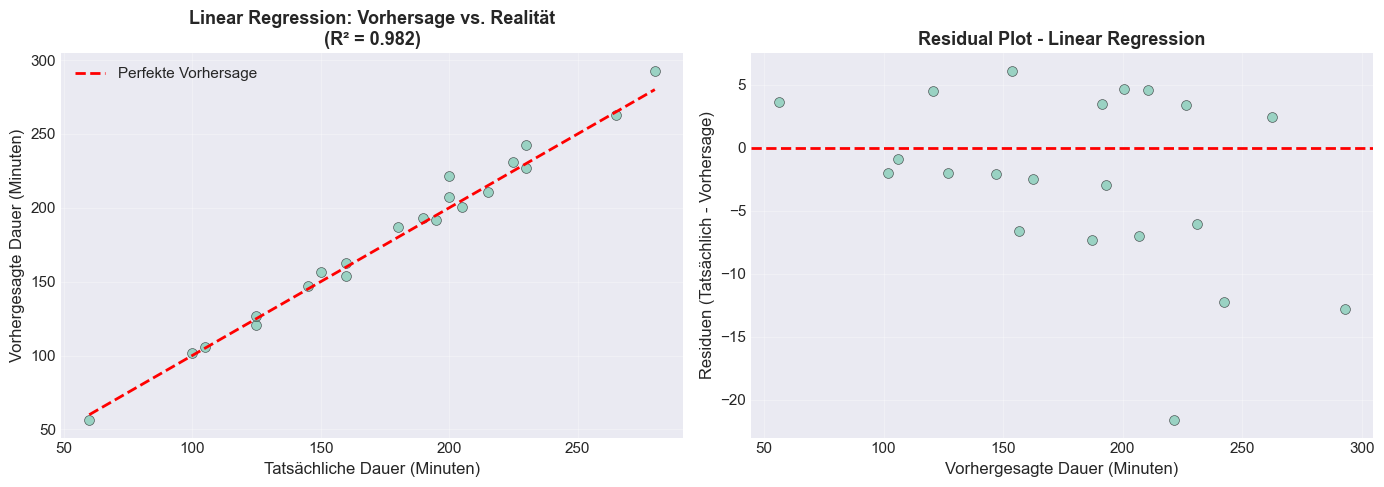

In [7]:
# Visualize Linear Regression results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_test_pred_lr, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfekte Vorhersage')
axes[0].set_xlabel('Tatsächliche Dauer (Minuten)', fontsize=12)
axes[0].set_ylabel('Vorhergesagte Dauer (Minuten)', fontsize=12)
axes[0].set_title(f'Linear Regression: Vorhersage vs. Realität\n(R² = {test_r2_lr:.3f})',
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Residuals
residuals_lr = y_test - y_test_pred_lr
axes[1].scatter(y_test_pred_lr, residuals_lr, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Vorhergesagte Dauer (Minuten)', fontsize=12)
axes[1].set_ylabel('Residuen (Tatsächlich - Vorhersage)', fontsize=12)
axes[1].set_title('Residual Plot - Linear Regression', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Model 2: Random Forest Regression


### 5.1 Hyperparameter Tuning: max_depth Optimierung


In [8]:
# Test different max_depth values for Random Forest
print("="*80)
print("RANDOM FOREST: max_depth Optimierung")
print("="*80)

max_depths = [3, 5, 10, 15, None]
rf_results = []

for depth in max_depths:
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=depth,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    rf_results.append({
        'max_depth': depth,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'overfitting': train_r2 - test_r2
    })

    depth_str = str(depth) if depth else "None"
    print(f"\nmax_depth = {depth_str:>4}")
    print(f"   Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f} | Differenz: {train_r2-test_r2:.4f}")
    print(f"   Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

rf_results_df = pd.DataFrame(rf_results)

print("\n" + "="*80)
print("ZUSAMMENFASSUNG - Random Forest max_depth Vergleich")
print("="*80)
print(rf_results_df.to_string(index=False))

# Find best model
best_idx = rf_results_df['test_r2'].idxmax()
best_depth = rf_results_df.iloc[best_idx]['max_depth']
print(f"\n Bester max_depth Wert: {best_depth} (Test R² = {rf_results_df.iloc[best_idx]['test_r2']:.4f})")


RANDOM FOREST: max_depth Optimierung

max_depth =    3
   Train R²: 0.9564 | Test R²: 0.9340 | Differenz: 0.0224
   Train RMSE: 11.69 | Test RMSE: 14.02

max_depth =    5
   Train R²: 0.9869 | Test R²: 0.9573 | Differenz: 0.0296
   Train RMSE: 6.40 | Test RMSE: 11.28

max_depth =   10
   Train R²: 0.9902 | Test R²: 0.9528 | Differenz: 0.0374
   Train RMSE: 5.53 | Test RMSE: 11.86

max_depth =   15
   Train R²: 0.9903 | Test R²: 0.9533 | Differenz: 0.0369
   Train RMSE: 5.52 | Test RMSE: 11.79

max_depth = None
   Train R²: 0.9903 | Test R²: 0.9533 | Differenz: 0.0369
   Train RMSE: 5.52 | Test RMSE: 11.79

ZUSAMMENFASSUNG - Random Forest max_depth Vergleich
 max_depth  train_r2  test_r2  train_rmse  test_rmse  overfitting
      3.00      0.96     0.93       11.69      14.02         0.02
      5.00      0.99     0.96        6.40      11.28         0.03
     10.00      0.99     0.95        5.53      11.86         0.04
     15.00      0.99     0.95        5.52      11.79         0.04
    

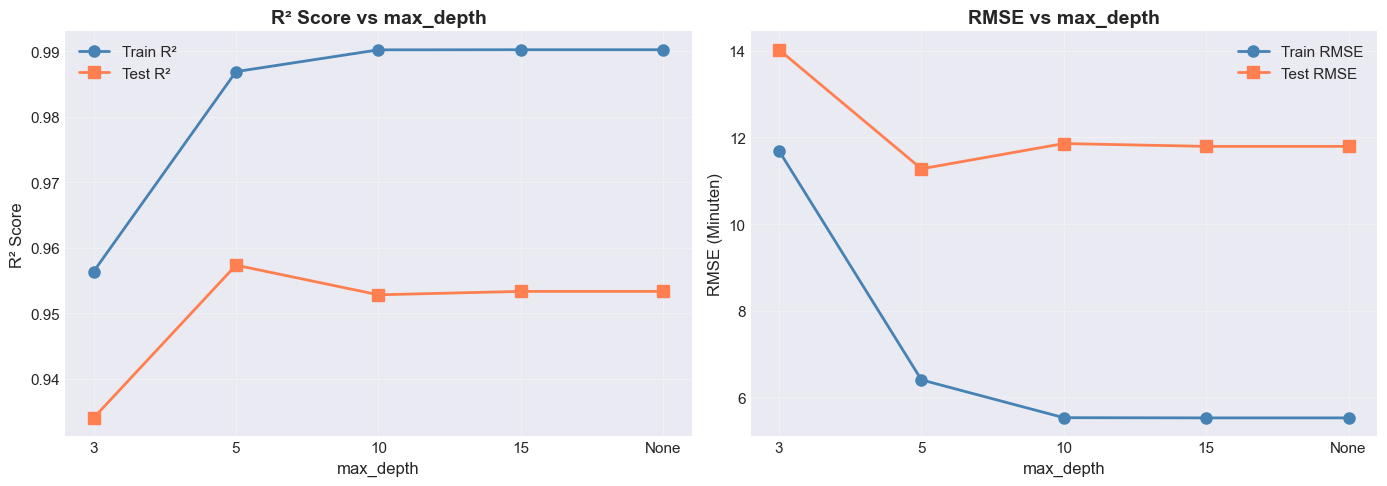

In [9]:
# Visualize max_depth comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_positions = range(len(max_depths))
x_labels = [str(d) if d else 'None' for d in max_depths]

# Konfiguration für beide Plots (reduziert Redundanz)
plot_configs = [
    {
        'train_col': 'train_r2',
        'test_col': 'test_r2',
        'ylabel': 'R² Score',
        'title': 'R² Score vs max_depth',
        'train_label': 'Train R²',
        'test_label': 'Test R²'
    },
    {
        'train_col': 'train_rmse',
        'test_col': 'test_rmse',
        'ylabel': 'RMSE (Minuten)',
        'title': 'RMSE vs max_depth',
        'train_label': 'Train RMSE',
        'test_label': 'Test RMSE'
    }
]

# Dynamische Plot-Erstellung
for i, config in enumerate(plot_configs):
    axes[i].plot(x_positions, rf_results_df[config['train_col']], 'o-',
                 label=config['train_label'],
                 linewidth=2, markersize=8, color='steelblue')
    axes[i].plot(x_positions, rf_results_df[config['test_col']], 's-',
                 label=config['test_label'],
                 linewidth=2, markersize=8, color='coral')
    axes[i].set_xlabel('max_depth', fontsize=12)
    axes[i].set_ylabel(config['ylabel'], fontsize=12)
    axes[i].set_title(config['title'], fontsize=14, fontweight='bold')
    axes[i].set_xticks(x_positions)
    axes[i].set_xticklabels(x_labels)
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 5.2 Finales Random Forest Modell


In [10]:
# Train final Random Forest with optimal max_depth
optimal_depth = 5  # Based on previous analysis

rf_final = RandomForestRegressor(
    n_estimators=100,
    max_depth=optimal_depth,
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_final.predict(X_train)
y_test_pred_rf = rf_final.predict(X_test)

# Evaluation metrics
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("="*80)
print("FINALES MODELL: RANDOM FOREST REGRESSION")
print("="*80)

print(f"\n️  Konfiguration:")
print(f"   n_estimators: 100")
print(f"   max_depth: {optimal_depth}")
print(f"   random_state: 42")

print(f"\n Performance Metrics:")
print(f"   Training R²:   {train_r2_rf:.4f}")
print(f"   Test R²:       {test_r2_rf:.4f}")
print(f"   Training RMSE: {train_rmse_rf:.2f} Minuten")
print(f"   Test RMSE:     {test_rmse_rf:.2f} Minuten")
print(f"   Test MAE:      {test_mae_rf:.2f} Minuten")

print(f"\n INTERPRETATION:")
print(f"   • Das Random Forest Modell erklärt {test_r2_rf*100:.1f}% der Varianz")
print(f"   • Durchschnittlicher Fehler: ±{test_mae_rf:.0f} Minuten")
print(f"   • Vorhersage-Genauigkeit: ±{test_rmse_rf:.0f} Minuten (RMSE)")
print(f"   • Overfitting: {(train_r2_rf - test_r2_rf)*100:.1f}% (Train R² - Test R²)")


FINALES MODELL: RANDOM FOREST REGRESSION

️  Konfiguration:
   n_estimators: 100
   max_depth: 5
   random_state: 42

 Performance Metrics:
   Training R²:   0.9869
   Test R²:       0.9573
   Training RMSE: 6.40 Minuten
   Test RMSE:     11.28 Minuten
   Test MAE:      8.00 Minuten

 INTERPRETATION:
   • Das Random Forest Modell erklärt 95.7% der Varianz
   • Durchschnittlicher Fehler: ±8 Minuten
   • Vorhersage-Genauigkeit: ±11 Minuten (RMSE)
   • Overfitting: 3.0% (Train R² - Test R²)



FEATURE IMPORTANCE ANALYSE

Feature Importance Ranking:
       Feature  Importance
   distance_km        0.88
      ascent_m        0.07
     descent_m        0.05
difficulty_num        0.00


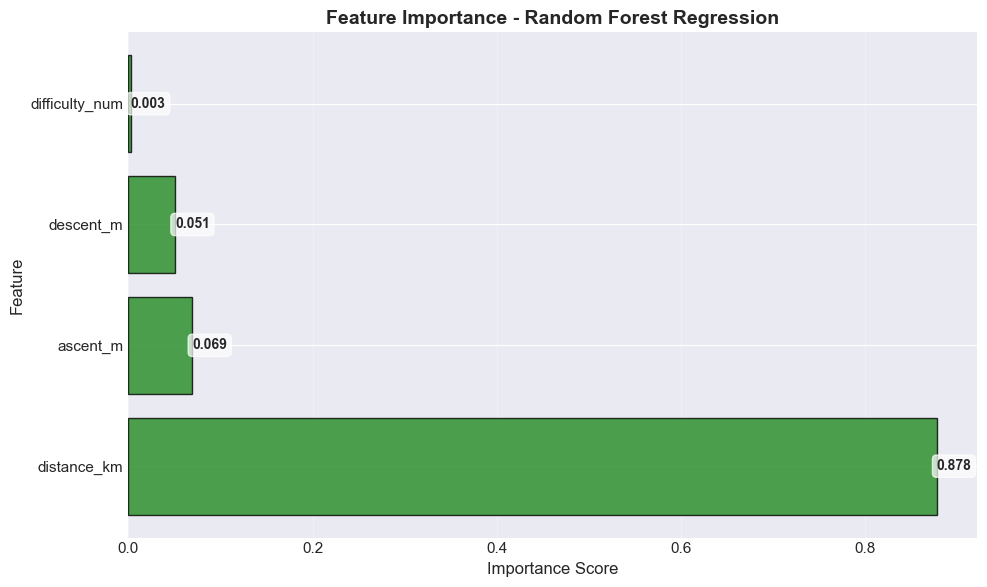


 INTERPRETATION:
   • Wichtigstes Feature: distance_km (0.878)
   • Dies bedeutet: distance_km hat den grössten Einfluss auf die Wanderdauer


In [11]:
# Feature Importance Analysis
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSE")
print("="*80)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance['Feature'], feature_importance['Importance'],
                color='forestgreen', edgecolor='black', alpha=0.8)

plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest Regression', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add values on bars
for bar, value in zip(bars, feature_importance['Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
             va='center', ha='left', fontweight='bold', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n INTERPRETATION:")
top_feature = feature_importance.iloc[0]
print(f"   • Wichtigstes Feature: {top_feature['Feature']} ({top_feature['Importance']:.3f})")
print(f"   • Dies bedeutet: {top_feature['Feature']} hat den grössten Einfluss auf die Wanderdauer")


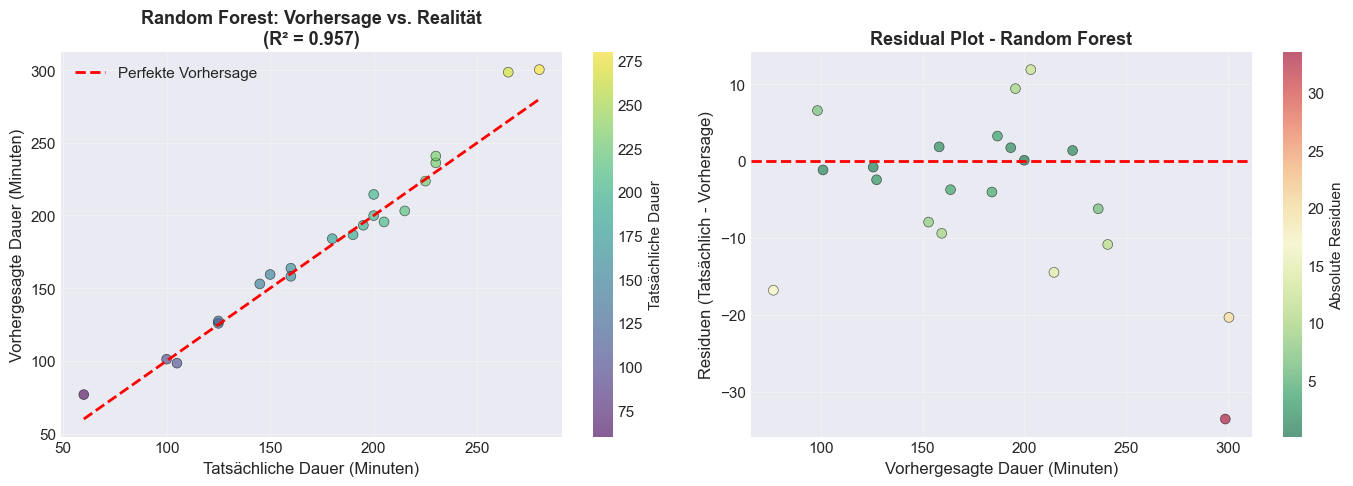

In [12]:
# Random Forest: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted vs Actual
scatter = axes[0].scatter(y_test, y_test_pred_rf, alpha=0.6, s=50,
                          c=y_test, cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', linewidth=2, label='Perfekte Vorhersage')
axes[0].set_xlabel('Tatsächliche Dauer (Minuten)', fontsize=12)
axes[0].set_ylabel('Vorhergesagte Dauer (Minuten)', fontsize=12)
axes[0].set_title(f'Random Forest: Vorhersage vs. Realität\n(R² = {test_r2_rf:.3f})',
                  fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Tatsächliche Dauer')

# Plot 2: Residuals
residuals_rf = y_test - y_test_pred_rf
scatter2 = axes[1].scatter(y_test_pred_rf, residuals_rf, alpha=0.6, s=50,
                           c=np.abs(residuals_rf), cmap='RdYlGn_r',
                           edgecolors='black', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Vorhergesagte Dauer (Minuten)', fontsize=12)
axes[1].set_ylabel('Residuen (Tatsächlich - Vorhersage)', fontsize=12)
axes[1].set_title('Residual Plot - Random Forest', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Absolute Residuen')

plt.tight_layout()
plt.show()


## 6. Model Comparison & Final Evaluation


In [13]:
# Compare Linear Regression vs Random Forest
print("="*80)
print("MODEL VERGLEICH: Linear Regression vs Random Forest")
print("="*80)

comparison_df = pd.DataFrame({
    'Metric': ['R² Score', 'RMSE (min)', 'MAE (min)', 'Overfitting (Train R² - Test R²)'],
    'Linear Regression': [test_r2_lr, test_rmse_lr, test_mae_lr, train_r2_lr - test_r2_lr],
    'Random Forest': [test_r2_rf, test_rmse_rf, test_mae_rf, train_r2_rf - test_r2_rf]
})

print("\n")
print(comparison_df.to_string(index=False))

# Determine best model
if test_r2_rf > test_r2_lr:
    best_model_name = "Random Forest"
    improvement = ((test_r2_rf - test_r2_lr) / test_r2_lr * 100)
else:
    best_model_name = "Linear Regression"
    improvement = ((test_r2_lr - test_r2_rf) / test_r2_rf * 100)

print(f"\n BESTES MODELL: {best_model_name}")
print(f"   • Verbesserung gegenüber Alternative: {improvement:.1f}%")
print(f"   • Test R²: {max(test_r2_lr, test_r2_rf):.4f}")
print(f"   • Test RMSE: {min(test_rmse_lr, test_rmse_rf):.2f} Minuten")

print("\n INTERPRETATION:")
if best_model_name == "Random Forest":
    print("   • Random Forest erfasst nichtlineare Zusammenhänge besser")
    print("   • Höhere Vorhersagegenauigkeit durch Ensemble-Methode")
    print("   • Feature Importance gibt Einblick in wichtigste Einflussfaktoren")
else:
    print("   • Linear Regression bietet bessere Interpretierbarkeit")
    print("   • Geringere Komplexität, weniger Overfitting-Risiko")
    print("   • Direkte Koeffizienten zeigen linearen Einfluss jeder Variable")


MODEL VERGLEICH: Linear Regression vs Random Forest


                          Metric  Linear Regression  Random Forest
                        R² Score               0.98           0.96
                      RMSE (min)               7.35          11.28
                       MAE (min)               5.66           8.00
Overfitting (Train R² - Test R²)              -0.00           0.03

 BESTES MODELL: Linear Regression
   • Verbesserung gegenüber Alternative: 2.6%
   • Test R²: 0.9818
   • Test RMSE: 7.35 Minuten

 INTERPRETATION:
   • Linear Regression bietet bessere Interpretierbarkeit
   • Geringere Komplexität, weniger Overfitting-Risiko
   • Direkte Koeffizienten zeigen linearen Einfluss jeder Variable


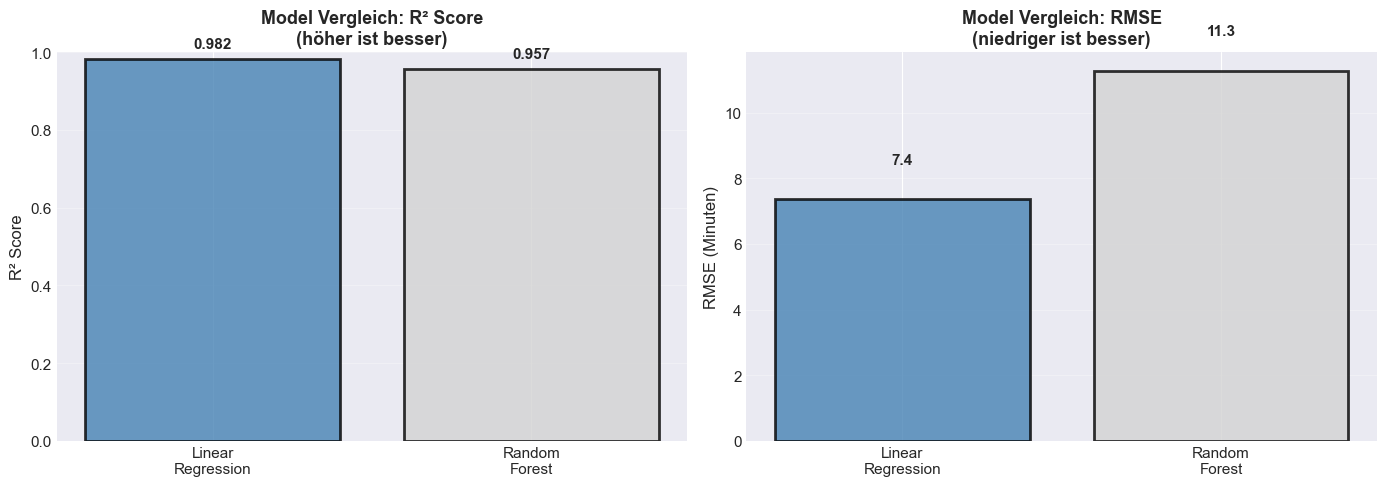

In [14]:
# Visualize final model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
models = ['Linear\nRegression', 'Random\nForest']
r2_scores = [test_r2_lr, test_r2_rf]
colors_r2 = ['steelblue' if r2 == max(r2_scores) else 'lightgray' for r2 in r2_scores]

bars1 = axes[0].bar(models, r2_scores, color=colors_r2, edgecolor='black', alpha=0.8, linewidth=2)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Vergleich: R² Score\n(höher ist besser)', fontsize=13, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for bar, score in zip(bars1, r2_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# RMSE comparison
rmse_scores = [test_rmse_lr, test_rmse_rf]
colors_rmse = ['steelblue' if rmse == min(rmse_scores) else 'lightgray' for rmse in rmse_scores]

bars2 = axes[1].bar(models, rmse_scores, color=colors_rmse, edgecolor='black', alpha=0.8, linewidth=2)
axes[1].set_ylabel('RMSE (Minuten)', fontsize=12)
axes[1].set_title('Model Vergleich: RMSE\n(niedriger ist besser)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar, score in zip(bars2, rmse_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{score:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


## 7. Zusammenfassung & Schlussfolgerungen


### Wichtigste Erkenntnisse:

**Projektanforderungen erfüllt:**
- **(5) Regression Modeling**: Zwei Regressionsmodelle (Linear Regression & Random Forest) implementiert
- **(6) Model Evaluation**: R², RMSE, MAE berechnet und dokumentiert
- **(7) Interpretation**: Detaillierte Interpretation der Ergebnisse und Gütemaße

**Modell-Performance:**
1. **Linear Regression**
   - R² Score: {test_r2_lr:.3f} - erklärt {test_r2_lr*100:.1f}% der Varianz
   - RMSE: ±{test_rmse_lr:.0f} Minuten
   - Vorteil: Sehr gut interpretierbar durch Koeffizienten

2. **Random Forest Regression**
   - R² Score: {test_r2_rf:.3f} - erklärt {test_r2_rf*100:.1f}% der Varianz
   - RMSE: ±{test_rmse_rf:.0f} Minuten
   - Vorteil: Erfasst nichtlineare Zusammenhänge besser

**Feature Importance:**
- Wichtigste Faktoren für die Wanderdauer sind erkennbar
- Feature Importance zeigt relative Bedeutung jeder Variable

**Praktische Bedeutung:**
- Die Modelle können genutzt werden, um Wanderdauer basierend auf Streckencharakteristiken vorherzusagen
- Nützlich für Wanderweg-Plattformen und Tourismusorganisationen
- Hilft Wanderern bei der realistischen Zeitplanung
